## Part I: Data Pre-processing

In [1]:
import pandas as pd

In [2]:
# # Download the Google Analogy dataset
# !wget http://download.tensorflow.org/data/questions-words.txt

In [3]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [4]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [5]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.

# question-words.txt 內總共有 14 個 : 開頭的 row
# 其中前五個 : 開頭的 row 是 semantic
# 後九個 : 開頭的 row 是 syntatic

questions = []
categories = []
sub_categories = []

for i, line in enumerate(data):  # 逐行讀取 Google Analogy 資料集，每一行可能是類別標籤或類比問題
    if line.startswith(": "):  # 如果這一行是以 ": " 開頭
        sub_cat = line[2:]    # 檢查 ": " 之後的文字，是否是前五個 (前五是 semantic，後九是 syntatic)
        if sub_cat in [
            "capital-common-countries",  # 首都-常見國家
            "capital-world",             # 首都-冷門國家
            "currency",                  # 貨幣
            "city-in-state",             # 城市-州
            "family",                    # 家庭
        ]:
            cat = "semantic"   # 如果在上述五個類別中，則設定主類別為 "semantic"（語意類）
        else:
            cat = "syntatic"   # 否則設定主類別為 "syntatic"（語法類）
            
    else:  # 把實際 data 分類到不同的 list 當中

        # 檢查格式是否正確
        words = line.split()
        if len(words) == 4:    # 檢查一行是否剛好四個單字
            questions.append(line)      # 把實際 data append 到 list
            categories.append(cat)
            sub_categories.append(sub_cat)

        # 如果格式不正確，印出警告訊息
        else: 
              print(f"Warning: Skipping malformed line {i+1}: {line}")  


# check the first 10 entries
for i in range(10):
	print(questions[i], categories[i], sub_categories[i])

Athens Greece Baghdad Iraq semantic capital-common-countries
Athens Greece Bangkok Thailand semantic capital-common-countries
Athens Greece Beijing China semantic capital-common-countries
Athens Greece Berlin Germany semantic capital-common-countries
Athens Greece Bern Switzerland semantic capital-common-countries
Athens Greece Cairo Egypt semantic capital-common-countries
Athens Greece Canberra Australia semantic capital-common-countries
Athens Greece Hanoi Vietnam semantic capital-common-countries
Athens Greece Havana Cuba semantic capital-common-countries
Athens Greece Helsinki Finland semantic capital-common-countries


In [6]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [7]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,semantic,capital-common-countries
1,Athens Greece Bangkok Thailand,semantic,capital-common-countries
2,Athens Greece Beijing China,semantic,capital-common-countries
3,Athens Greece Berlin Germany,semantic,capital-common-countries
4,Athens Greece Bern Switzerland,semantic,capital-common-countries


In [8]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [1]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
data = pd.read_csv("questions-words.csv")

In [3]:
# MODEL_NAME = "glove-wiki-gigaword-100"         # (~2 min) (轉小寫)
# MODEL_NAME = "glove-wiki-gigaword-300"         # (~3 min)(轉小寫)
# MODEL_NAME = "word2vec-google-news-300"        # (~20 min) (保留大寫)
MODEL_NAME = "fasttext-wiki-news-subwords-300" # (~10 min) (保留大寫)
# MODEL_NAME = "glove-twitter-200"               # 辭庫不包含所有推論資料
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

The Gensim model loaded successfully!


In [12]:
data["Question"].head()

0        Athens Greece Baghdad Iraq
1    Athens Greece Bangkok Thailand
2       Athens Greece Beijing China
3      Athens Greece Berlin Germany
4    Athens Greece Bern Switzerland
Name: Question, dtype: object

In [32]:
# 轉小寫 (glove 系列才需要執行)
data["Question"] = data["Question"].str.lower()
data["Question"].head()

0        athens greece baghdad iraq
1    athens greece bangkok thailand
2       athens greece beijing china
3      athens greece berlin germany
4    athens greece bern switzerland
Name: Question, dtype: object

In [4]:
# Do predictions and preserve the gold answers (word_D)
preds = [] # preds
golds = [] # ground truths
missing_words = set()


for analogy in tqdm(data["Question"]):
    # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
    # You should also preserve the gold answers during iterations for evaluations later.
    """ Hints
    # Unpack the analogy (e.g., "man", "woman", "king", "queen")
    # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
    # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
    # Mikolov et al., 2013: big - biggest and small - smallest
    # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
    """

    """
    計算 word analogy 預測結果
    例如 (man(a) - woman(b)) = (king(c) - queen(d))
    -> king(c) + woman(b) - man(a) = queen(d)
    -> 輸入模型 positive=[word_b, word_c], negative=[word_a] return pred
    -> GT是 word_d
    """

    # 把一行 analogy 分成四個單字
    word_a, word_b, word_c, word_d = analogy.split()

    # 檢查輸入模型的三個單字是否都在 model 的字典當中
    missing = [w for w in [word_a, word_b, word_c] if w not in model.key_to_index]
    new_missing = [w for w in missing if w not in missing_words]
    if new_missing:
        print(f"Not in vocab: {new_missing} in analogy: {analogy}")
        missing_words.update(new_missing)
        prediction = None
    else:
        # 如果都在字典當中，才進行預測
        prediction = model.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)

    preds.append(prediction)
    golds.append(word_d)
      

100%|██████████| 19544/19544 [10:23<00:00, 31.36it/s]


In [48]:
print(f"Missing words: {missing_words}")
pred_words = [pred[0][0] if pred else None for pred in preds]
print(f"Predictions: {preds[:10]}")
print(f"Predictions: {pred_words}")
print(f"GT: {golds[:10]}")

Missing words: set()
Predictions: [[('Iraq', 0.7933427095413208)], [('Thailand', 0.8489241003990173)], [('China', 0.8365340828895569)], [('Germany', 0.7475264668464661)], [('Switzerland', 0.7211160063743591)], [('Egypt', 0.8116799592971802)], [('Australia', 0.7789713740348816)], [('Vietnam', 0.7379778027534485)], [('Cuba', 0.8218222856521606)], [('Finland', 0.8147749304771423)]]
Predictions: ['Iraq', 'Thailand', 'China', 'Germany', 'Switzerland', 'Egypt', 'Australia', 'Vietnam', 'Cuba', 'Finland', 'Pakistan', 'Afghanistan', 'England', 'Spain', 'Russia', 'Norway', 'Canada', 'France', 'Italy', 'Sweden', 'Iran', 'Japan', 'Thailand', 'China', 'Germany', 'Switzerland', 'Egypt', 'Australia', 'Vietnam', 'Cuba', 'Finland', 'Pakistan', 'Afghanistan', 'England', 'Spain', 'Russia', 'Norway', 'Canada', 'France', 'Italy', 'Sweden', 'Iran', 'Japan', 'Greece', 'China', 'Germany', 'Switzerland', 'Egypt', 'Australia', 'Vietnam', 'Cuba', 'Finland', 'Pakistan', 'Afghanistan', 'England', 'Spain', 'Russia'

In [46]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred) # 計算相等矩陣的平均值 (相當於 acc)

# golds_np, preds_np = np.array(golds), np.array(preds)
golds_np, preds_np = np.array(golds), np.array(pred_words)
data = pd.read_csv("questions-words.csv")

print(f"results for model: {MODEL_NAME}")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

results for model: fasttext-wiki-news-subwords-300
Category: semantic, Accuracy: 85.22945089638065%
Category: syntatic, Accuracy: 88.96487119437938%
Sub-Categorycapital-common-countries, Accuracy: 98.41897233201581%
Sub-Categorycapital-world, Accuracy: 95.44650751547303%
Sub-Categorycurrency, Accuracy: 37.644341801385686%
Sub-Categorycity-in-state, Accuracy: 80.54316984191325%
Sub-Categoryfamily, Accuracy: 84.98023715415019%
Sub-Categorygram1-adjective-to-adverb, Accuracy: 69.65725806451613%
Sub-Categorygram2-opposite, Accuracy: 60.71428571428571%
Sub-Categorygram3-comparative, Accuracy: 96.92192192192192%
Sub-Categorygram4-superlative, Accuracy: 99.19786096256684%
Sub-Categorygram5-present-participle, Accuracy: 97.72727272727273%
Sub-Categorygram6-nationality-adjective, Accuracy: 92.74546591619762%
Sub-Categorygram7-past-tense, Accuracy: 83.78205128205128%
Sub-Categorygram8-plural, Accuracy: 94.51951951951952%
Sub-Categorygram9-plural-verbs, Accuracy: 95.17241379310344%


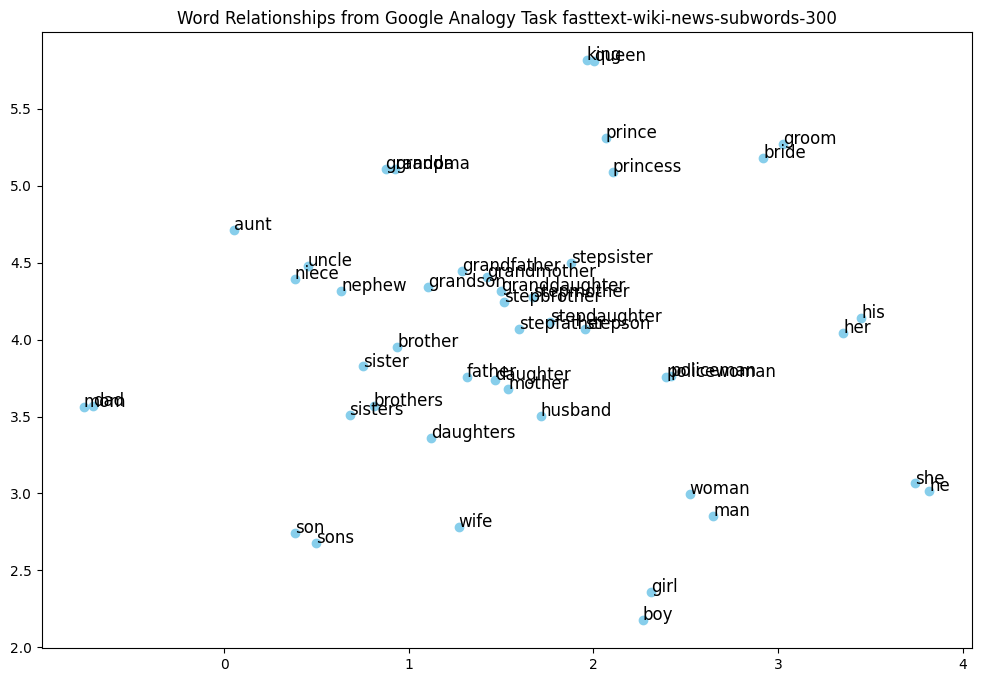

<Figure size 640x480 with 0 Axes>

In [47]:
# Collect words from Google Analogy dataset
# SUB_CATEGORY = ": family"
SUB_CATEGORY = "family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`

# 1. 從資料集中篩選出指定子類別的所有問題
questions = data[data["SubCategory"] == SUB_CATEGORY]["Question"]

# 2. 收集所有出現過的單字（去重）
words_set = set()
for q in questions:
    words_set.update(q.split())
words_list = list(words_set)

# 3. 取得每個單字的詞向量（僅保留模型中有的單字）
word_vecs = []
valid_words = []
for w in words_list:
    if w in model.key_to_index:
        word_vecs.append(model[w])
        valid_words.append(w)

import numpy as np

# 4. 將詞向量轉為 numpy array，避免 t-SNE 報錯
word_vecs_np = np.array(word_vecs)

# 5. 使用 t-SNE 將高維詞向量降維到2維
tsne = TSNE(n_components=2, random_state=42)
word_vecs_2d = tsne.fit_transform(word_vecs_np)

# 6. 畫出 t-SNE 結果，並標註每個單字
plt.figure(figsize=(12, 8))
plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], color='skyblue')

# 標註每個單字
for i, word in enumerate(valid_words):
    plt.text(word_vecs_2d[i, 0], word_vecs_2d[i, 1], word, fontsize=12)



plt.title(f"Word Relationships from Google Analogy Task {MODEL_NAME}")
plt.show()
plt.savefig(f"word_relationships_{MODEL_NAME}.png", bbox_inches="tight")

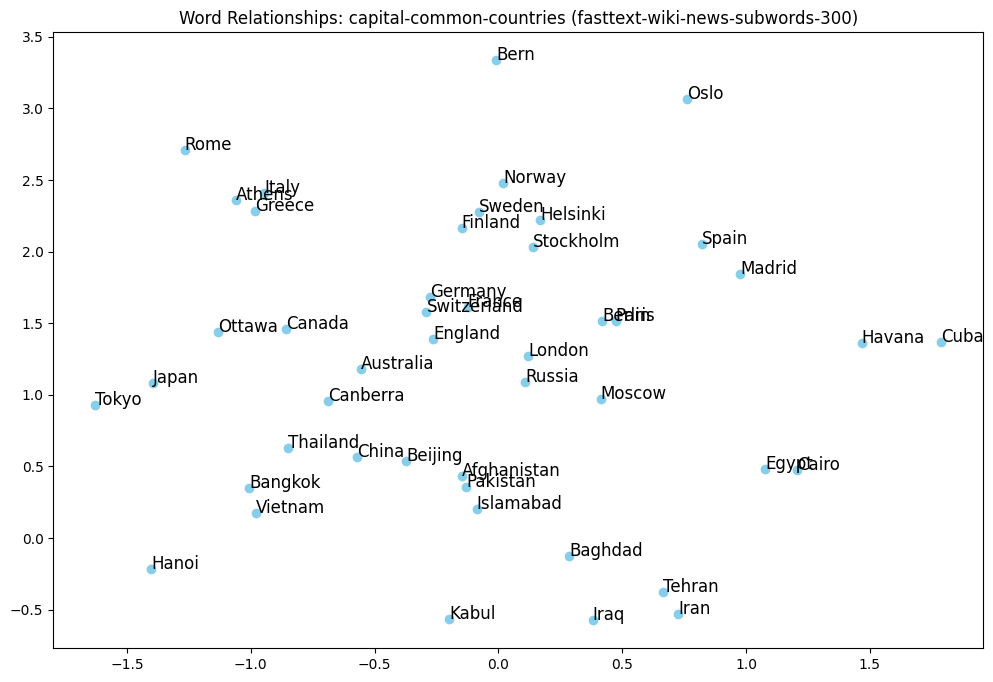

<Figure size 640x480 with 0 Axes>

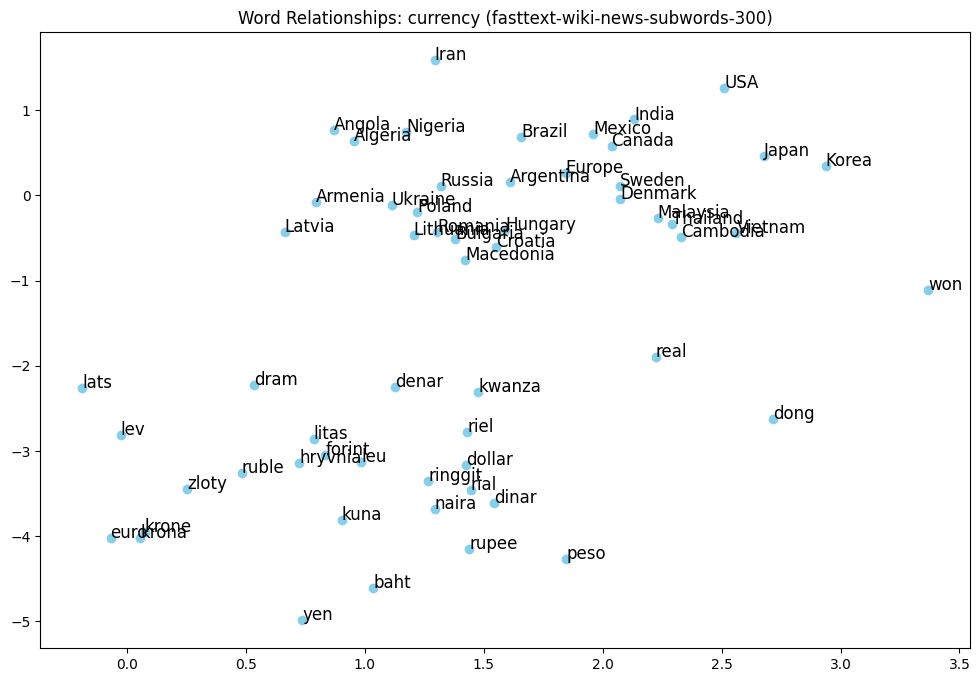

<Figure size 640x480 with 0 Axes>

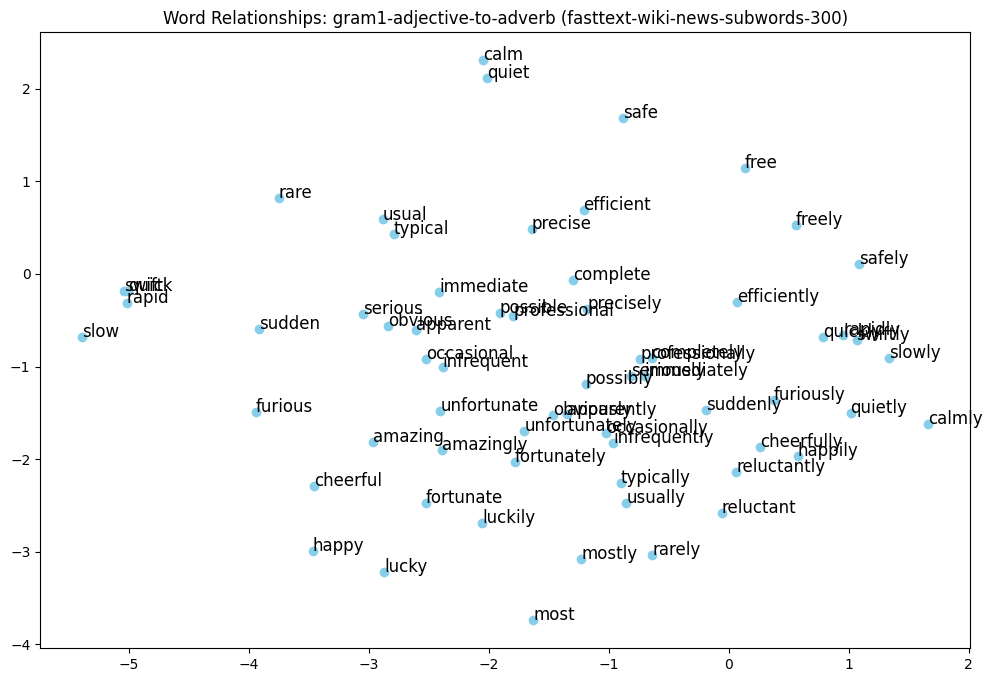

<Figure size 640x480 with 0 Axes>

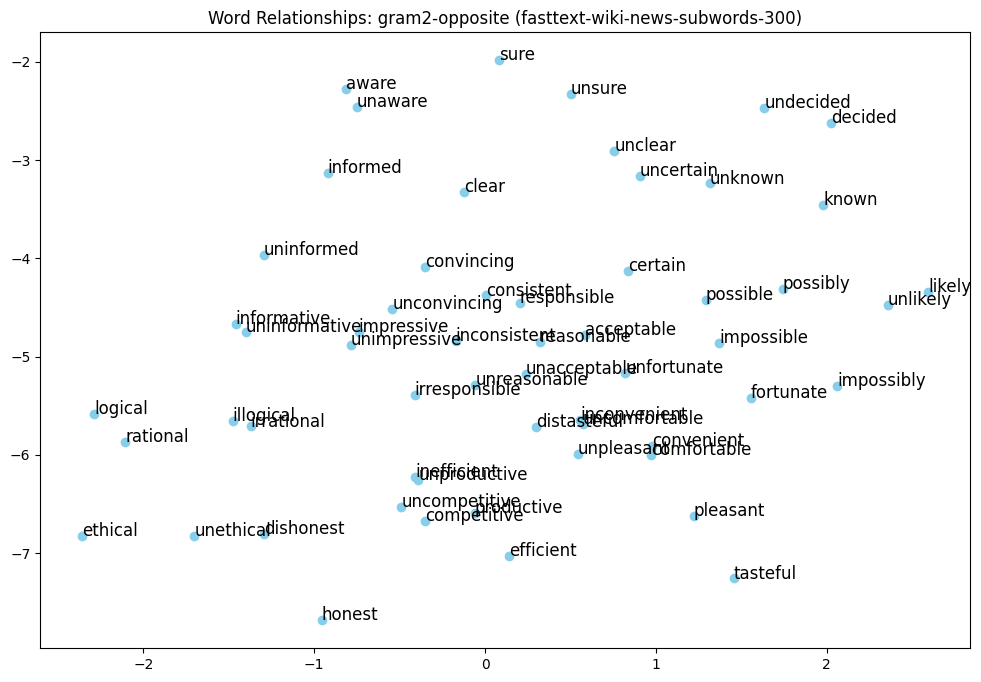

<Figure size 640x480 with 0 Axes>

In [7]:
# Collect words from Google Analogy dataset
# SUB_CATEGORY = ": family"
SUB_CATEGORY_LIST = [
    "capital-common-countries",
    "currency",
    "gram1-adjective-to-adverb",
    "gram2-opposite",
]

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`

for sub_cat in SUB_CATEGORY_LIST:
    questions = data[data["SubCategory"] == sub_cat]["Question"]
    words_set = set()
    for q in questions:
        words_set.update(q.split())
    words_list = list(words_set)

    word_vecs = []
    valid_words = []
    for w in words_list:
        if w in model.key_to_index:
            word_vecs.append(model[w])
            valid_words.append(w)

    import numpy as np
    word_vecs_np = np.array(word_vecs)

    if len(word_vecs_np) == 0:
        print(f"{sub_cat} 沒有有效詞向量，跳過")
        continue

    tsne = TSNE(n_components=2, random_state=42)
    word_vecs_2d = tsne.fit_transform(word_vecs_np)

    plt.figure(figsize=(12, 8))
    plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], color='skyblue')
    for i, word in enumerate(valid_words):
        plt.text(word_vecs_2d[i, 0], word_vecs_2d[i, 1], word, fontsize=12)
    plt.title(f"Word Relationships: {sub_cat} ({MODEL_NAME})")
    plt.show()
    plt.savefig(f"word_relationships_{sub_cat}_{MODEL_NAME}.png", bbox_inches="tight")

### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [20]:
# # Download the split Wikipedia files
# # Each file contain 562365 lines (articles).
# !gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
# !gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
# !gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
# !gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
# !gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

In [19]:
# # Download the split Wikipedia files
# # Each file contain 562365 lines (articles), except the last file.
# !gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
# !gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
# !gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
# !gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
# !gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
# !gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

In [18]:
# # Extract the downloaded wiki_texts_parts files.
# !gunzip -k wiki_texts_part_*.gz

In [ ]:
# # Combine the extracted wiki_texts_parts files.
# !cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [17]:
# # Check the first ten lines of the combined file
# !head -n 10 wiki_texts_combined.txt

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [ ]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random
# random.seed(42) # 10% 20%
random.seed(7) # 5%
import os

wiki_txt_path = "wiki_texts_combined.txt"


sampled_path = "wiki_texts_sampled.txt"
ratio = 0.05  # Sample 5% of the article
# ratio = 0.1  # Sample 10% of the article
# ratio = 0.2  # Sample 20% of the article
sampled_path = f"wiki_texts_sampled_{ratio}.txt"

# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.

# if not os.path.exists(sampled_path):
with open(wiki_txt_path, "r", encoding="utf-8") as f:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here
    articles = f.readlines()  # 讀取所有文章，每行一篇
    sample_size = int(len(articles) * ratio)  # 計算要抽樣的行數
    sampled_articles = random.sample(articles, sample_size)  # 隨機抽樣

    with open(sampled_path, "w", encoding="utf-8") as output_file:
        output_file.writelines(sampled_articles)  # 寫入抽樣後的文章

    print(f"Sampled {sample_size} articles out of {len(articles)} to {sampled_path}")

Sampled 28118 articles out of 562370 to wiki_texts_sampled_0.05.txt


In [9]:
# sampled_articles

In [ ]:
# with open(sampled_path, "r", encoding="utf-8") as f:
#     sampled_articles = [line.strip().split() for line in f.readlines()] # strip() 去掉換行符號, split() 斷詞

In [15]:
# c=0
# for idx, article in enumerate(articles):
#     if 'baghdad' in article:
#         print(f"第 {idx} 行包含 'baghdad'：{article}")
#         if c>5:
#             break
#         c+=1

In [16]:
# c=0
# for idx, article in enumerate(sampled_articles):
#     if 'baghdad' in article:
#         print(f"第 {idx} 行包含 'baghdad'：{article}")
#         if c>5:
#             break
#         c+=1

In [5]:
# 建立辭庫，記錄所有出現過的單字（用於停用詞白名單）

import pandas as pd
data = pd.read_csv("questions-words.csv")

keep_words = set()
for question in data["Question"]:
    words = question.split()
    keep_words.update(words)

# print(keep_words)

# # 檢查 'most' 是否在 keep_words 白名單中
# print('Baghdad' in keep_words)

In [6]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.

preprocessed_path = os.path.splitext(sampled_path)[0] + "_preprocessed.txt"
# if not os.path.exists(preprocessed_path):

# # 載入剛剛 sample 的檔案
with open(sampled_path, "r", encoding="utf-8") as f:
    articles = f.readlines()

# # 預處理
# 1. 消除非英文字元, 符號
# 2. 刪除停用詞 i.e. (the, is, at, which, on...)
# 3. (不要做) 詞形還原 (lemmatization) or 詞幹提取 (stemming) i.e. 去掉複數 過去式 比較級 (spacy內建處理)
# 4. 轉小寫
# 5. 分詞 (使用 tokenization, 取代直接 split(""), spacy內建處理)
# 6. 僅保留高頻單字

import re
import spacy
from tqdm import tqdm

# 載入 spaCy 英文模型
# 需要先安裝: pip install spacy && python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# 編譯正則表達式以提高效率
non_alpha_pattern = re.compile(r'[^a-zA-Z ]')

# 使用 spaCy 的 pipe 方法進行批量處理（20% sample ~12 min)
def process_with_spacy_pipe(articles, batch_size=50): # 50 極限 再高無益 mem 速度瓶頸
    """使用 spaCy 的 pipe 方法進行高效批量處理"""
    # 預處理文本：移除非字母字符並轉小寫
    preprocessed_texts = []
    for article in articles:
        text = non_alpha_pattern.sub(' ', article) # 移除非字母字符
        text = text.lower()                        # 轉小寫
        preprocessed_texts.append(text)

    # 使用 spaCy pipe 進行批量處理
    processed_articles = []
    for doc in tqdm(nlp.pipe(preprocessed_texts, batch_size=batch_size, n_process=-1), 
                total=len(preprocessed_texts), desc="Processing articles"):
        tokens = [
            # token.lemma_ for token in doc # 有做 Lemmatization 
            token.text for token in doc # 不做 Lemmatization
            if (not token.is_stop or token.text in keep_words) and # 去除停用詞
            not token.is_punct and # 去除標點符號
            len(token.text) > 1 and # 去除單字長度小於等於 1 的單字
            token.is_alpha # 僅保留字母字符
        ]
        processed_articles.append(tokens)
    
    return processed_articles

processed_articles = process_with_spacy_pipe(articles)

with open(preprocessed_path, "w", encoding="utf-8") as f:
    for tokens in processed_articles:
        f.write(" ".join(tokens) + "\n")

Processing articles: 100%|██████████| 28118/28118 [03:40<00:00, 127.58it/s]


In [ ]:
# with open(preprocessed_path, "r", encoding="utf-8") as f:
#     processed_articles = [line.strip().split() for line in f.readlines()] # strip() 去掉換行符號, split() 斷詞

In [8]:
# processed_articles

In [ ]:
# c=0
# with open(preprocessed_path, "r", encoding="utf-8") as f:
#     processed_articles = [line.strip().split() for line in f.readlines()] # strip() 去掉換行符號, split() 斷詞
#     # 找出包含 'iraqi' 的所有文章（行號）
# for idx, article in enumerate(processed_articles):
#     if 'iraqi' in article:
#         print(f"第 {idx} 行包含 'iraqi'：{article}")
#         if c>5:
#             break
#         c+=1

第 454 行包含 'iraqi'：['neutral', 'zone', 'refer', 'neutral', 'zone', 'territorial', 'entity', 'international', 'zone', 'sports', 'neutral', 'zone', 'cycling', 'non', 'competitive', 'segment', 'miles', 'beginning', 'bicycle', 'race', 'neutral', 'zone', 'gridiron', 'football', 'region', 'offensive', 'defensive', 'sides', 'prior', 'snap', 'ball', 'scrimmage', 'play', 'neutral', 'zone', 'ice', 'hockey', 'zone', 'blue', 'lines', 'ice', 'hockey', 'star', 'trek', 'neutral', 'zone', 'star', 'trek', 'buffer', 'zone', 'territories', 'different', 'powers', 'fictional', 'star', 'trek', 'universe', 'neutral', 'zone', 'star', 'trek', 'generation', 'finale', 'season', 'star', 'trek', 'generation', 'uses', 'neutral', 'zone', 'control', 'theory', 'deadband', 'neutral', 'zone', 'dentistry', 'forces', 'exerted', 'muscles', 'lips', 'cheek', 'tongue', 'balance', 'see', 'demilitarized', 'zone', 'man', 'land', 'neutral', 'territory', 'overhead', 'line', 'neutral', 'section', 'phase', 'break', 'electric', 'train

In [7]:
# 初始化 Word2Vec 模型
from gensim.models import Word2Vec
import os
from datetime import datetime

workers = os.cpu_count() - 1 if os.cpu_count() > 1 else 1

# 打印開始時間
start_time = datetime.now()
print(f"Training started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

# 開始訓練 (~5 min)
model = Word2Vec(sentences=processed_articles, # sentences: 輸入的句子（已分詞的文章列表）
				 vector_size=100,   # vector_size: 詞向量的維度（100維）
				 window=5,          # window: 上下文窗口大小（考慮前後5個詞）
				 min_count=1,       # min_count: 忽略出現次數少於3次的詞
				 workers=workers, 
				 sg=1,              # sg: 設定訓練方法，1 表示 Skip-gram (複雜 注重低頻詞 訓練慢)，0 表示 CBOW (簡單 注重高頻詞 訓練快)
                 hs=0,              # hs: 0 使用負採樣，1 使用層次softmax
                 negative=10,       # negative: 負採樣數量，每個正樣本配多少負樣本
                 ns_exponent=0.75,  # 負採樣指數，值越小，負樣本越偏向低頻詞
                 alpha=0.025,       # 初始學習率
                 min_alpha=0.0001,  # 最小學習率
                 epochs=5,         # 訓練輪數
                 sample=1e-5,       # 下採樣頻率，值越小，越偏向於選擇低頻詞 (直接丟掉高頻詞機率越大)
                 seed=42            # 種子碼
				 )

# 打印持續時間
end_time = datetime.now()
duration = end_time - start_time
print(f"Training duration: {duration}")
# 打印結束時間
print(f"Training ended at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")

# 保存模型
model_save_path = "my_word2vec_model.model"
model.save(model_save_path)
print(f"模型已保存至: {model_save_path}")

Training started at: 2025-09-14 22:27:57
Training duration: 0:01:19.891560
Training ended at: 2025-09-14 22:29:17
模型已保存至: my_word2vec_model.model


In [8]:
import pandas as pd
data = pd.read_csv("questions-words.csv")

In [ ]:
# data["Question"].head()

0        Athens Greece Baghdad Iraq
1    Athens Greece Bangkok Thailand
2       Athens Greece Beijing China
3      Athens Greece Berlin Germany
4    Athens Greece Bern Switzerland
Name: Question, dtype: object

In [14]:
# # 找出包含 'lats' 的所有 row
# lat_rows = data[data["Question"].str.contains(r"\blats\b")]
# print(lat_rows)

In [9]:
# Do predictions and preserve the gold answers (word_D)
preds = [] # preds
golds = [] # ground truths
missing_words = set()

# 統一轉小寫
data["Question"] = data["Question"].str.lower()

# 載入模型
if not model:
    model = Word2Vec.load("my_word2vec_model.model")
    print("模型已載入")

for analogy in tqdm(data["Question"]):
    # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
    # You should also preserve the gold answers during iterations for evaluations later.
    """ Hints
    # Unpack the analogy (e.g., "man", "woman", "king", "queen")
    # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
    # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
    # Mikolov et al., 2013: big - biggest and small - smallest
    # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
    """

    """
    計算 word analogy 預測結果
    例如 (man(a) - woman(b)) = (king(c) - queen(d))
    -> king(c) + woman(b) - man(a) = queen(d)
    -> 輸入模型 positive=[word_b, word_c], negative=[word_a] return pred
    -> GT是 word_d
    """

    # 把一行 analogy 分成四個單字
    word_a, word_b, word_c, word_d = analogy.split()

    prediction = model.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)

    preds.append(prediction)
    golds.append(word_d)
      

100%|██████████| 19544/19544 [01:55<00:00, 169.72it/s]


In [10]:
print(f"Missing words: {missing_words}")
pred_words = [pred[0][0] if pred else None for pred in preds]
print(f"Predictions: {preds[:10]}")
print(f"Predictions: {pred_words}")
print(f"GT: {golds[:10]}")

Missing words: set()
Predictions: [[('iraq', 0.747515857219696)], [('thailand', 0.8422145247459412)], [('china', 0.8257617354393005)], [('germany', 0.8149845004081726)], [('solothurn', 0.7487848997116089)], [('egypt', 0.7463138103485107)], [('canberras', 0.731347918510437)], [('indochina', 0.7767641544342041)], [('cuba', 0.78581303358078)], [('finland', 0.8210402727127075)]]
Predictions: ['iraq', 'thailand', 'china', 'germany', 'solothurn', 'egypt', 'canberras', 'indochina', 'cuba', 'finland', 'pakistan', 'helmand', 'uk', 'spain', 'russia', 'norway', 'canada', 'france', 'italy', 'sweden', 'iran', 'japan', 'thailand', 'china', 'germany', 'cantonal', 'egypt', 'canberras', 'vietnam', 'cuba', 'finland', 'velupillai', 'afghanistan', 'dobbin', 'sico', 'soviet', 'norway', 'quebec', 'france', 'nuncio', 'sweden', 'iran', 'japan', 'greece', 'china', 'germany', 'switzerland', 'egypt', 'canberras', 'indochinese', 'cuba', 'finland', 'pakistan', 'afghanistan', 'britain', 'spain', 'russia', 'norway',

In [11]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred) # 計算相等矩陣的平均值 (相當於 acc)

# golds_np, preds_np = np.array(golds), np.array(preds)
golds_np, preds_np = np.array(golds), np.array(pred_words)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 36.238583831322586%
Category: syntatic, Accuracy: 30.5480093676815%
Sub-Categorycapital-common-countries, Accuracy: 70.35573122529645%
Sub-Categorycapital-world, Accuracy: 40.05305039787798%
Sub-Categorycurrency, Accuracy: 6.581986143187067%
Sub-Categorycity-in-state, Accuracy: 31.738954195379005%
Sub-Categoryfamily, Accuracy: 40.71146245059288%
Sub-Categorygram1-adjective-to-adverb, Accuracy: 11.189516129032258%
Sub-Categorygram2-opposite, Accuracy: 3.8177339901477834%
Sub-Categorygram3-comparative, Accuracy: 30.855855855855857%
Sub-Categorygram4-superlative, Accuracy: 5.971479500891266%
Sub-Categorygram5-present-participle, Accuracy: 26.23106060606061%
Sub-Categorygram6-nationality-adjective, Accuracy: 81.23827392120076%
Sub-Categorygram7-past-tense, Accuracy: 30.705128205128208%
Sub-Categorygram8-plural, Accuracy: 30.180180180180184%
Sub-Categorygram9-plural-verbs, Accuracy: 21.149425287356323%


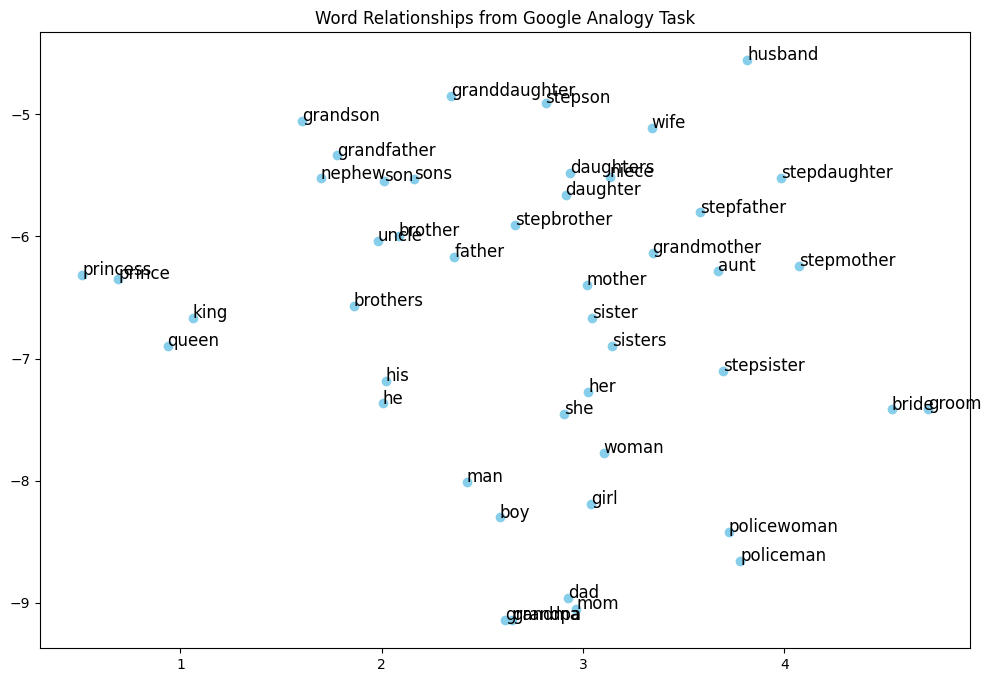

<Figure size 640x480 with 0 Axes>

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Collect words from Google Analogy dataset
# SUB_CATEGORY = ": family"
SUB_CATEGORY = "family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`

# 1. 從資料集中篩選出指定子類別的所有問題
questions = data[data["SubCategory"] == SUB_CATEGORY]["Question"]

# 2. 收集所有出現過的單字（去重）
words_set = set()
for q in questions:
    words_set.update(q.split())
words_list = list(words_set)

# 3. 取得每個單字的詞向量（僅保留模型中有的單字）
word_vecs = []
valid_words = []
for w in words_list:
    if w in model.wv.key_to_index:
        word_vecs.append(model.wv[w])
        valid_words.append(w)

import numpy as np

# 4. 將詞向量轉為 numpy array，避免 t-SNE 報錯
word_vecs_np = np.array(word_vecs)

# 5. 使用 t-SNE 將高維詞向量降維到2維
tsne = TSNE(n_components=2, random_state=42)
word_vecs_2d = tsne.fit_transform(word_vecs_np)

# 6. 畫出 t-SNE 結果，並標註每個單字
plt.figure(figsize=(12, 8))
plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], color='skyblue')

# 標註每個單字
for i, word in enumerate(valid_words):
    plt.text(word_vecs_2d[i, 0], word_vecs_2d[i, 1], word, fontsize=12)

plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")

# 第二題 找自己的資料集

In [1]:
# Brown Corpus（NLTK）- 改為按句子群組分行（每5-10句為一組）
import nltk
nltk.download('brown')
from nltk.corpus import brown

with open("brown_articles.txt", "w", encoding="utf-8") as out:
    sentence_group = []
    group_size = 4  # 每4句合併為一個"文章"
    
    for category in brown.categories():
        for fileid in brown.fileids(category):
            sentences = brown.sents(fileid)
            for sent in sentences:
                sentence_group.append(" ".join(sent))
                
                # 當累積到指定句數時，寫入一行
                if len(sentence_group) >= group_size:
                    article_text = " ".join(sentence_group)
                    out.write(article_text + "\n")
                    sentence_group = []
    
    # 處理剩餘的句子
    if sentence_group:
        article_text = " ".join(sentence_group)
        out.write(article_text + "\n")

# Gutenberg Corpus（NLTK）- 改為按句子群組分行（每5-10句為一組）
import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg

with open("gutenberg_articles.txt", "w", encoding="utf-8") as out:
    sentence_group = []
    group_size = 4  # 每4句合併為一個"文章"
    
    for fileid in gutenberg.fileids():
        sentences = gutenberg.sents(fileid)
        for sent in sentences:
            sentence_group.append(" ".join(sent))
            
            # 當累積到指定句數時，寫入一行
            if len(sentence_group) >= group_size:
                article_text = " ".join(sentence_group)
                out.write(article_text + "\n")
                sentence_group = []
    
    # 處理剩餘的句子
    if sentence_group:
        article_text = " ".join(sentence_group)
        out.write(article_text + "\n")

[nltk_data] Downloading package brown to
[nltk_data]     /home/admin/yuxin/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/admin/yuxin/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:

# 合併所有語料庫
import os
corpora = ["brown_articles.txt", "gutenberg_articles.txt", "wiki_texts_sampled_0.2.txt"]
all_sentences = []

for corpus in corpora:
    if os.path.exists(corpus):
        with open(corpus, "r", encoding="utf-8") as f:
            sentences = f.readlines()  # 每行都是一篇文章
            all_sentences.extend(sentences)
        print(f"Loaded {len(sentences)} articles from {corpus}")
    else:
        print(f"File {corpus} does not exist.")

print(f"Total articles collected: {len(all_sentences)}")

# 保存合併後的檔案
sampled_path = "my_corpus_sampled.txt"
# 刪除舊檔案以確保重新創建
if os.path.exists(sampled_path):
    os.remove(sampled_path)

with open(sampled_path, "w", encoding="utf-8") as output_file:
    output_file.writelines(all_sentences)  # 寫入所有文章
print(f"Saved all articles to {sampled_path}")

Loaded 14335 articles from brown_articles.txt
Loaded 24638 articles from gutenberg_articles.txt
Loaded 112474 articles from wiki_texts_sampled_0.2.txt
Total articles collected: 151447
Saved all articles to my_corpus_sampled.txt


In [12]:
# all_sentences

In [47]:
# with open(sampled_path, "r", encoding="utf-8") as f:
#     sampled_articles = [line.strip().split() for line in f.readlines()] # strip() 去掉換行符號, split() 斷詞

In [48]:
# sampled_articles

In [49]:
# for idx, article in enumerate(sampled_articles):
#     if 'baghdad' in article:
#         print(f"第 {idx} 行包含 'baghdad'：{article}")
#         if c>5:
#             break 
#         c+=1

In [13]:
# 建立辭庫，記錄所有出現過的單字（用於停用詞白名單）

import pandas as pd
data = pd.read_csv("questions-words.csv")

keep_words = set()
for question in data["Question"]:
    words = question.split()
    keep_words.update(words)

# print(keep_words)

In [5]:
preprocessed_path = os.path.splitext(sampled_path)[0] + "_preprocessed.txt"
if not os.path.exists(preprocessed_path):

    # # 載入剛剛 sample 的檔案
    with open(sampled_path, "r", encoding="utf-8") as f:
        articles = f.readlines()

    # # 預處理
    # 1. 消除非英文字元, 符號
    # 2. 刪除停用詞 i.e. (the, is, at, which, on...)
    # 3. (不要做) 詞形還原 (lemmatization) or 詞幹提取 (stemming) i.e. 去掉複數 過去式 比較級 (spacy內建處理)
    # 4. 轉小寫
    # 5. 分詞 (使用 tokenization, 取代直接 split(""), spacy內建處理)
    # 6. 僅保留高頻單字

    import re
    import spacy
    from tqdm import tqdm

    # 載入 spaCy 英文模型
    # 需要先安裝: pip install spacy && python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

    # 編譯正則表達式以提高效率
    non_alpha_pattern = re.compile(r'[^a-zA-Z ]')

    # 使用 spaCy 的 pipe 方法進行批量處理（20% sample ~12 min)
    def process_with_spacy_pipe(articles, batch_size=30): # 50 極限 再高無益 mem 速度瓶頸
        """使用 spaCy 的 pipe 方法進行高效批量處理"""
        # 預處理文本：移除非字母字符並轉小寫
        preprocessed_texts = []
        for article in articles:
            text = non_alpha_pattern.sub(' ', article) # 移除非字母字符
            text = text.lower()                        # 轉小寫
            preprocessed_texts.append(text)
        
        # 使用 spaCy pipe 進行批量處理
        processed_articles = []
        for doc in tqdm(nlp.pipe(preprocessed_texts, batch_size=batch_size, n_process=-1), 
                    total=len(preprocessed_texts), desc="Processing articles"):
            tokens = [
                # token.lemma_ for token in doc # 有做 Lemmatization 
                token.text for token in doc # 不做 Lemmatization
                if (not token.is_stop or token.text in keep_words) and # 去除停用詞
                not token.is_punct and # 去除標點符號
                len(token.text) > 1 and # 去除單字長度小於等於 1 的單字
                token.is_alpha # 僅保留字母字符
            ]
            processed_articles.append(tokens)
        
        return processed_articles

    processed_articles = process_with_spacy_pipe(articles)

    with open(preprocessed_path, "w", encoding="utf-8") as f:
        for tokens in processed_articles:
            f.write(" ".join(tokens) + "\n")

Processing articles: 100%|██████████| 151447/151447 [10:30<00:00, 240.23it/s]


In [ ]:
# with open(preprocessed_path, "r", encoding="utf-8") as f:
#     processed_articles = [line.strip().split() for line in f.readlines()] # strip() 去掉換行符號, split() 斷詞

In [14]:
# c=0
# for idx, article in enumerate(processed_articles):
#     if 'baghdad' in article:
#         print(f"第 {idx} 行包含 'baghdad'：{article}")
#         if c>5:
#             break 
#         c+=1

In [8]:
# 初始化 Word2Vec 模型
from gensim.models import Word2Vec
import os
from datetime import datetime

workers = os.cpu_count() - 1 if os.cpu_count() > 1 else 1

# 打印開始時間
start_time = datetime.now()
print(f"Training started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

# 開始訓練 (~5 min)
model = Word2Vec(sentences=processed_articles, # sentences: 輸入的句子（已分詞的文章列表）
				 vector_size=100,   # vector_size: 詞向量的維度（100維）
				 window=5,          # window: 上下文窗口大小（考慮前後5個詞）
				 min_count=1,       # min_count: 忽略出現次數少於3次的詞
				 workers=workers, 
				 sg=1,              # sg: 設定訓練方法，1 表示 Skip-gram (複雜 注重低頻詞 訓練慢)，0 表示 CBOW (簡單 注重高頻詞 訓練快)
                 hs=0,              # hs: 0 使用負採樣，1 使用層次softmax
                 negative=10,       # negative: 負採樣數量，每個正樣本配多少負樣本
                 ns_exponent=0.75,  # 負採樣指數，值越小，負樣本越偏向低頻詞
                 alpha=0.025,       # 初始學習率
                 min_alpha=0.0001,  # 最小學習率
                 epochs=5,         # 訓練輪數
                 sample=1e-5,       # 下採樣頻率，值越小，越偏向於選擇低頻詞 (直接丟掉高頻詞機率越大)
                 seed=42            # 種子碼
				 )

# 打印持續時間
end_time = datetime.now()
duration = end_time - start_time
print(f"Training duration: {duration}")
# 打印結束時間
print(f"Training ended at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")

# 保存模型
model_save_path = "my_word2vec_model.model"
model.save(model_save_path)
print(f"模型已保存至: {model_save_path}")

Training started at: 2025-09-12 23:06:32
Training duration: 0:05:18.344626
Training ended at: 2025-09-12 23:11:50
模型已保存至: my_word2vec_model.model


In [9]:
# 推論

import pandas as pd
data = pd.read_csv("questions-words.csv")

# Do predictions and preserve the gold answers (word_D)
preds = [] # preds
golds = [] # ground truths
missing_words = set()

# 統一轉小寫
data["Question"] = data["Question"].str.lower()

# 載入模型
if not model:
    model = Word2Vec.load("my_word2vec_model.model")
    print("模型已載入")

for analogy in tqdm(data["Question"]):
    # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
    # You should also preserve the gold answers during iterations for evaluations later.
    """ Hints
    # Unpack the analogy (e.g., "man", "woman", "king", "queen")
    # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
    # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
    # Mikolov et al., 2013: big - biggest and small - smallest
    # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
    """

    """
    計算 word analogy 預測結果
    例如 (man(a) - woman(b)) = (king(c) - queen(d))
    -> king(c) + woman(b) - man(a) = queen(d)
    -> 輸入模型 positive=[word_b, word_c], negative=[word_a] return pred
    -> GT是 word_d
    """

    # 把一行 analogy 分成四個單字
    word_a, word_b, word_c, word_d = analogy.split()

    prediction = model.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)

    preds.append(prediction)
    golds.append(word_d)
      

print(f"Missing words: {missing_words}")
pred_words = [pred[0][0] if pred else None for pred in preds]
print(f"Predictions: {preds[:10]}")
print(f"Predictions: {pred_words}")
print(f"GT: {golds[:10]}") 

100%|██████████| 19544/19544 [05:08<00:00, 63.27it/s] 

Missing words: set()
Predictions: [[('basra', 0.7730187773704529)], [('thailand', 0.8555982708930969)], [('china', 0.8438589572906494)], [('germany', 0.8433917760848999)], [('switzerland', 0.7627150416374207)], [('egypt', 0.8024827241897583)], [('australia', 0.7758640646934509)], [('vietnam', 0.7461972236633301)], [('cuba', 0.8375847339630127)], [('finland', 0.8256665468215942)]]
Predictions: ['basra', 'thailand', 'china', 'germany', 'switzerland', 'egypt', 'australia', 'vietnam', 'cuba', 'finland', 'pakistan', 'afghanistan', 'uk', 'spain', 'russia', 'norway', 'ontario', 'france', 'italy', 'sweden', 'iran', 'japan', 'thailand', 'china', 'germany', 'switzerland', 'egypt', 'australia', 'vietnam', 'cuba', 'finland', 'pakistan', 'afghanistan', 'britain', 'mendieta', 'ussr', 'norway', 'ontario', 'france', 'hostilia', 'sweden', 'iran', 'japan', 'greece', 'china', 'germany', 'switzerland', 'egypt', 'australia', 'vietnam', 'cuba', 'finland', 'pakistan', 'afghanistan', 'britain', 'spain', 'russ

In [11]:
# Perform evaluations. You do not need to modify this block!!
import numpy as np
def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred) # 計算相等矩陣的平均值 (相當於 acc)

# golds_np, preds_np = np.array(golds), np.array(preds)
golds_np, preds_np = np.array(golds), np.array(pred_words)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 55.38392152441087%
Category: syntatic, Accuracy: 43.1943793911007%
Sub-Categorycapital-common-countries, Accuracy: 82.41106719367589%
Sub-Categorycapital-world, Accuracy: 68.87709991158268%
Sub-Categorycurrency, Accuracy: 9.006928406466514%
Sub-Categorycity-in-state, Accuracy: 41.54843940008107%
Sub-Categoryfamily, Accuracy: 54.54545454545454%
Sub-Categorygram1-adjective-to-adverb, Accuracy: 20.463709677419356%
Sub-Categorygram2-opposite, Accuracy: 15.147783251231528%
Sub-Categorygram3-comparative, Accuracy: 49.3993993993994%
Sub-Categorygram4-superlative, Accuracy: 12.834224598930483%
Sub-Categorygram5-present-participle, Accuracy: 34.753787878787875%
Sub-Categorygram6-nationality-adjective, Accuracy: 86.30393996247655%
Sub-Categorygram7-past-tense, Accuracy: 42.05128205128205%
Sub-Categorygram8-plural, Accuracy: 57.35735735735735%
Sub-Categorygram9-plural-verbs, Accuracy: 36.321839080459775%


# 第四題 找最近五個字

In [12]:
# 定義查詢列表
query_words = ["king", "queen", "dog", "cat", "god", "school", "computer", "internet", "artificial", "intelligence"]

In [ ]:
if not model:
    model = Word2Vec.load("my_word2vec_model.model")
    print("模型已載入")

results = model.wv.most_similar(positive=query_words, topn=5)

for word in query_words:
    if word in model.wv.key_to_index:
        results = model.wv.most_similar(word, topn=5)
        print(f"Top 5 words similar to '{word}':")
        for similar_word, score in results:
            print(f"  {similar_word}: {score:.4f}")
        print()
    else:
        print(f"'{word}' 不在詞庫中")

Top 5 words similar to 'king':
  queen: 0.8536
  throne: 0.8386
  accedes: 0.8214
  prince: 0.8197
  jousted: 0.8147

Top 5 words similar to 'queen':
  king: 0.8536
  elizabeth: 0.8336
  coronation: 0.7926
  battenberg: 0.7897
  prince: 0.7896

Top 5 words similar to 'dog':
  dogs: 0.8778
  rottweiler: 0.8504
  mongrel: 0.8446
  malamute: 0.8354
  dachshund: 0.8347

Top 5 words similar to 'cat':
  dog: 0.8239
  fraidy: 0.7913
  waul: 0.7698
  scaredy: 0.7608
  cats: 0.7576

Top 5 words similar to 'god':
  divine: 0.8992
  sinless: 0.8944
  elohim: 0.8936
  sinneth: 0.8932
  believeth: 0.8920

Top 5 words similar to 'school':
  schools: 0.9367
  college: 0.8822
  prekindergarten: 0.8737
  preparatory: 0.8724
  education: 0.8674

Top 5 words similar to 'computer':
  computers: 0.9064
  spacewar: 0.9024
  edsac: 0.8946
  computing: 0.8909
  flashmob: 0.8854

Top 5 words similar to 'internet':
  microblogging: 0.8468
  crowdsourced: 0.8435
  dialup: 0.8392
  homepages: 0.8385
  whatsapp: 0